In [164]:
# import libraries
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as ssm
from statsmodels.stats.power import tt_ind_solve_power



In [ ]:
# Used function definitions

def welch_t(a, b): # t-stat calculationg for 2 samples with different means 
    numerator = a.mean() - b.mean()
    denom = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    """ Calculate Welch's t-statistic for two samples. """
    return np.abs(numerator/denom)

def welch_df(a, b): # calculating this allows you to work with other variables to get a p-value!
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

def p_value(a, b, two_sided=False):
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), round(df))
    
    if two_sided:
        return 2*p
    else:
        return p
    
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return abs(d)

In [165]:
conn = sqlite3.connect(r"C:\Users\josep\Desktop\CourseWork\phase_1\Phase1\dsc-case-study-hypothesis-testing\data\northWind.sqlite")
cur = conn.cursor()

table = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(table)

                    name
0               Employee
1               Category
2               Customer
3                Shipper
4               Supplier
5                  Order
6                Product
7            OrderDetail
8   CustomerCustomerDemo
9    CustomerDemographic
10                Region
11             Territory
12     EmployeeTerritory


In [166]:
# investigate data
cur.execute("""SELECT * 
               FROM Product
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]


In [167]:
df

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,Rhönbräu Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,Lakkalikööri,23,1,500 ml,18.00,57,0,20,0


In [168]:
cur.execute("""SELECT ProductId, ProductName, Quantity, Discount
               FROM Product p
               JOIN OrderDetail od
               ON p.id = od.productid""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,ProductId,ProductName,Quantity,Discount
0,11,Queso Cabrales,12,0.0
1,42,Singaporean Hokkien Fried Mee,10,0.0
2,72,Mozzarella di Giovanni,5,0.0
3,14,Tofu,9,0.0
4,51,Manjimup Dried Apples,40,0.0


In [169]:
cur.execute("""PRAGMA table_info(Product)""").fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'ProductName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'SupplierId', 'INTEGER', 1, None, 0),
 (3, 'CategoryId', 'INTEGER', 1, None, 0),
 (4, 'QuantityPerUnit', 'VARCHAR(8000)', 0, None, 0),
 (5, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (6, 'UnitsInStock', 'INTEGER', 1, None, 0),
 (7, 'UnitsOnOrder', 'INTEGER', 1, None, 0),
 (8, 'ReorderLevel', 'INTEGER', 1, None, 0),
 (9, 'Discontinued', 'INTEGER', 1, None, 0)]

In [170]:
cur.execute("""PRAGMA table_info('Order')""").fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'CustomerId', 'VARCHAR(8000)', 0, None, 0),
 (2, 'EmployeeId', 'INTEGER', 1, None, 0),
 (3, 'OrderDate', 'VARCHAR(8000)', 0, None, 0),
 (4, 'RequiredDate', 'VARCHAR(8000)', 0, None, 0),
 (5, 'ShippedDate', 'VARCHAR(8000)', 0, None, 0),
 (6, 'ShipVia', 'INTEGER', 0, None, 0),
 (7, 'Freight', 'DECIMAL', 1, None, 0),
 (8, 'ShipName', 'VARCHAR(8000)', 0, None, 0),
 (9, 'ShipAddress', 'VARCHAR(8000)', 0, None, 0),
 (10, 'ShipCity', 'VARCHAR(8000)', 0, None, 0),
 (11, 'ShipRegion', 'VARCHAR(8000)', 0, None, 0),
 (12, 'ShipPostalCode', 'VARCHAR(8000)', 0, None, 0),
 (13, 'ShipCountry', 'VARCHAR(8000)', 0, None, 0)]

In [171]:
df['Discount'].unique()
df.info()
df = df[['Quantity','Discount']]
df = df[df.Discount != .01]
df = df[df.Discount != .02]
df = df[df.Discount != .03]
df = df[df.Discount != .04]
df = df[df.Discount != .06]
df.info()
df.groupby(by='Discount').count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductId    2155 non-null   int64  
 1   ProductName  2155 non-null   object 
 2   Quantity     2155 non-null   int64  
 3   Discount     2155 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 67.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quantity  2147 non-null   int64  
 1   Discount  2147 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


,Quantity
Discount,
0.00,1317
0.05,185
0.10,173
0.15,157
0.20,161
0.25,154


# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [172]:
# obtain necessary data
df

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0
...,...,...
2147,2,0.0
2148,2,0.0
2151,1,0.0
2153,4,0.0


## {ANOVA Test}
H0: For each discount rate, the mean number of products sold is the same.

HA: At least one of the mean number of products sold by discount rate is different.

Alpha: 0.05

In [173]:
df_0 = df.loc[df['Discount'] == 0.00]
df_05 = df.loc[df['Discount'] == 0.05]
df_10 = df.loc[df['Discount'] == 0.10]
df_15 = df.loc[df['Discount'] == 0.15]
df_20 = df.loc[df['Discount'] == 0.20]
df_25 = df.loc[df['Discount'] == 0.25]

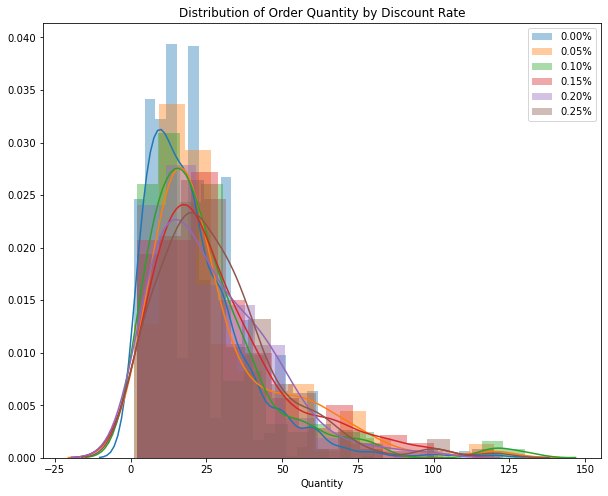

In [174]:

fig = plt.figure(figsize=(10,8))
sns.distplot(df_0['Quantity'], label='0.00%')
sns.distplot(df_05['Quantity'], label='0.05%')
sns.distplot(df_10['Quantity'], label='0.10%')
sns.distplot(df_15['Quantity'], label='0.15%')
sns.distplot(df_20['Quantity'], label='0.20%')
sns.distplot(df_25['Quantity'], label='0.25%')
plt.title('Distribution of Order Quantity by Discount Rate')
plt.legend()
plt.show()

In [175]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
# perform test

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


p is < alpha (0.05), therefore we can reject H0.

## Conclusion

Since our p value is less than alpha, we can reject our null hypothesis. Therefore, we can conclude that there is a difference in means between the quantity of products sold and their discount rate.
However, we cannot tell which discount rate is the most different, we only know that there is a difference. We can investigate further using a Tukey test to see which discount rate is the most different. 

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

In [176]:
multicompare_discount = ssm.MultiComparison(df['Quantity'], df['Discount'])
tukey_hsd = multicompare_discount.tukeyhsd()
tukey_hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.05,6.2955,0.001,2.0814,10.5097,True
0.0,0.1,3.5217,0.1885,-0.8187,7.8622,False
0.0,0.15,6.6669,0.001,2.1352,11.1986,True
0.0,0.2,5.3096,0.0096,0.8285,9.7907,True
0.0,0.25,6.525,0.001,1.954,11.096,True
0.05,0.1,-2.7738,0.704,-8.4504,2.9028,False
0.05,0.15,0.3714,0.9,-5.4528,6.1955,False
0.05,0.2,-0.986,0.9,-6.7708,4.7989,False
0.05,0.25,0.2294,0.9,-5.6253,6.0842,False
0.1,0.15,3.1452,0.6333,-2.771,9.0613,False


Tukey testing provides a pairwise comparison of quantities between each combination of discounts. From the data, we can see the lowest p-adj values for the following pairs- 0%-5%, 0%-15%, and 0-25%. Therefore, we can reject the null hypothesis that the mean quantities are the same for all comparisons for 0%-5%, 0%-15%, 0%-20%, 0%-25%. Interestingly, we could not reject the null hypothesis for the pair: 0%-10%, meaning that there is likely no difference in means between these two discounts. Because of this finding, we recommend NOT giving 10% dicounts, because the sales quantity doesn't change significantly based on that discount.

# Question 2: Is there a difference in number of orders and territory? 

In [177]:
cur.execute("""SELECT *
               FROM 'Order' o
               JOIN 'OrderDetail' od
               ON o.id = od.orderid
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
# obtain necessary data
df.ShipRegion.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [178]:
df = df[['Quantity','ShipRegion']]
count = df.groupby(by='ShipRegion').count()
df = df[df['ShipRegion'] != 'Eastern Europe']
df
count

,Quantity
ShipRegion,
British Isles,190
Central America,72
Eastern Europe,16
North America,427
Northern Europe,143
Scandinavia,70
South America,355
Southern Europe,137
Western Europe,745


## {ANOVA}
H0: The means of number of orders for each region are the same.

HA: The means of number of orders for each region are different.

Alpha = 0.05

In [179]:
df_BI = df.loc[df['ShipRegion'] == 'British Isles']
df_CA = df.loc[df['ShipRegion'] == 'Central America']
df_NA = df.loc[df['ShipRegion'] == 'North America']
df_SC = df.loc[df['ShipRegion'] == 'Scandinavia']
df_SA = df.loc[df['ShipRegion'] == 'South America']
df_SE = df.loc[df['ShipRegion'] == 'Southern Europe']
df_WE = df.loc[df['ShipRegion'] == 'Western Europe']

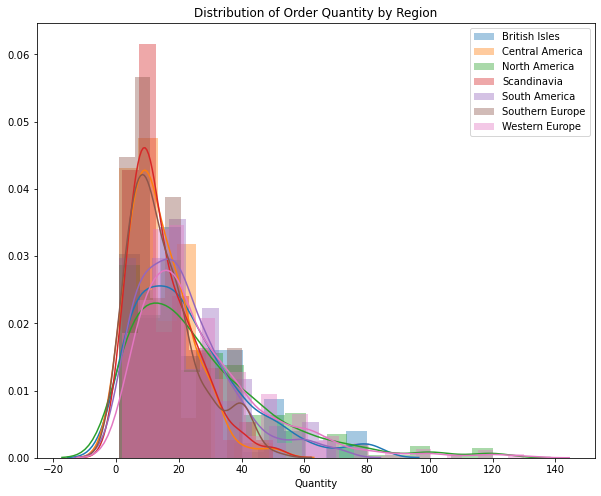

In [180]:
fig = plt.figure(figsize=(10,8))
sns.distplot(df_BI['Quantity'], label='British Isles')
sns.distplot(df_CA['Quantity'], label='Central America')
sns.distplot(df_NA['Quantity'], label='North America')
sns.distplot(df_SC['Quantity'], label='Scandinavia')
sns.distplot(df_SA['Quantity'], label='South America')
sns.distplot(df_SE['Quantity'], label='Southern Europe')
sns.distplot(df_WE['Quantity'], label='Western Europe')

plt.title('Distribution of Order Quantity by Region')
plt.legend()
plt.show()

In [181]:
# perform test
formula = 'Quantity ~ C(ShipRegion)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                      sum_sq      df          F        PR(>F)
C(ShipRegion)   36792.090822     7.0  15.144319  1.964648e-19
Residual       739588.451487  2131.0        NaN           NaN


Since our p-value is very close to 0 and less than alpha, we can reject our null hypothesis.

## Conclusion

Once again, our low p value allows us to reject H0. We can conclude that there is a difference in means between number of orders and region. We cannot say where the biggest difference lies, until we run our Tukey Test (below).

In [182]:
multicompare_discount = ssm.MultiComparison(df['Quantity'], df['ShipRegion'])
tukey_hsd = multicompare_discount.tukeyhsd()
tukey_hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-9.0586,0.0107,-16.8805,-1.2368,True
British Isles,North America,3.2018,0.5014,-1.7272,8.1307,False
British Isles,Northern Europe,0.5165,0.9,-5.7407,6.7736,False
British Isles,Scandinavia,-8.3519,0.0297,-16.2544,-0.4494,True
British Isles,South America,-2.106,0.9,-7.1865,2.9745,False
British Isles,Southern Europe,-8.1633,0.0024,-14.4982,-1.8285,True
British Isles,Western Europe,3.9549,0.1519,-0.6387,8.5485,False
Central America,North America,12.2604,0.001,5.0597,19.461,True
Central America,Northern Europe,9.5751,0.0091,1.4076,17.7425,True
Central America,Scandinavia,0.7067,0.9,-8.7803,10.1938,False


If we look at the order quantity by region, we can easily see that North America and Western Europe have the highest number of data. When we run the Tukey Test, we can see that the null hypothesis (no difference in means) is often rejected when any region compared to Western Europe or North America. For those two regions compared specifically to each other, our Tukey test tells us that we cannot reject the null hypothesis, indicating that they have similar mean order quantity. We recommend taking a further look at the mean order quantity between North America and Western Europe in order to determine whether or not there is a statistical difference.

# Question 3: Is there a significant difference in mean orders between North America or Western Europe?

In [183]:
# obtain necessary data

In [184]:
mean = df.groupby(by='ShipRegion').mean()
print(mean)
df_na = df.loc[df['ShipRegion'] == 'North America']
df_we = df.loc[df['ShipRegion'] == 'Western Europe']


                  Quantity
ShipRegion                
British Isles    23.294737
Central America  14.236111
North America    26.496487
Northern Europe  23.811189
Scandinavia      14.942857
South America    21.188732
Southern Europe  15.131387
Western Europe   27.249664


In [185]:
print(mean)

                  Quantity
ShipRegion                
British Isles    23.294737
Central America  14.236111
North America    26.496487
Northern Europe  23.811189
Scandinavia      14.942857
South America    21.188732
Southern Europe  15.131387
Western Europe   27.249664


## {Two-tailed T-Test}
H0: The mean orders between North America and Western Europe are the same.

HA: The mean order in North America and Western Europe are different.

Alpha: 0.05

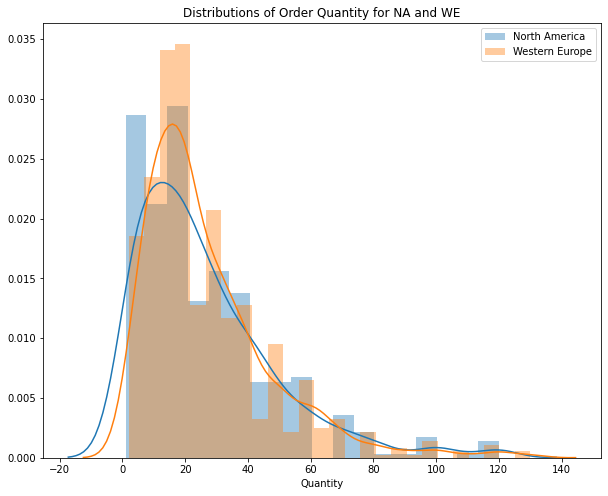

In [186]:
fig = plt.figure(figsize=(10,8))
sns.distplot(df_na['Quantity'], label='North America')
sns.distplot(df_we['Quantity'], label='Western Europe')
plt.title('Distributions of Order Quantity for NA and WE')
plt.legend()
plt.show()


In [188]:

p = p_value(df_na['Quantity'], df_we['Quantity'], two_sided=True)
p                                               

0.5729319587917252

## Conclusion

In conclusion, our p value is greater than alpha, meaning that we failed to reject our null hypothesis. The mean number of orders for North America and Western Europe are NOT different. 

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

In [191]:
effect_size = Cohen_d(df_na['Quantity'], df_we['Quantity'])
effect_size

0.03493509462200122

In [192]:
df_na.shape

(427, 2)

In [193]:
df_we.shape

(745, 2)

In [194]:
power = tt_ind_solve_power(effect_size=effect_size,
                           nobs1=df_na.shape[0],
                           alpha=0.05)
power

0.0802766124570253

This small effect size (<0.2) reinforces our previous finding that the means between North America and Western Europe product orders are the same. These two means differ by less than 0.2 standard deviations (AKA they are close together) indicating that their difference is trivial.

Power is only 0.08, and it is extremely low due to our small effect size. This means there is a strong probability of a type II error. Since we failed to reject our null hypothesis in this test, it makes sense that we have low power. 

## **Findings/Actionable Insights:**
There is no significant difference between mean number of orders in North America and Western Europe. They are the two regions with the highest mean number of orders, compared to all other regions. Therefore, when allocating budgets, we should consider this finding and potentially allocate an even amount of resources between the two of them. We should further investigate what is causing Scandinavia and Central America to have such low per order item quantities. Finally, we can also investigate which regions, if any, are not seeing increased item quantity as a result of the 10% discount.  